![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---

# Evaluación de GANs

En este cuaderno, vamos a comprender algunos de los retos que conlleva la evaluación de GANs y una de las métricas más utilizadas para ello: Distancia de Incepción de Fréchet (FID).

### Objetivos
1.   Comprender la dificultad de la evaluación de GANs.
2.   Escribir código para evaluar la Distancia de Incepción de Fréchet.


## Desafíos en la evaluación de GANs

#### La pérdida no informa sobre el rendimiento
Un aspecto que dificulta la evaluación de los GAN es que la pérdida nos dice poco sobre su rendimiento. A diferencia de los clasificadores, en los que una pérdida baja en un conjunto de prueba indica un rendimiento superior, una pérdida baja para el generador o discriminador sugiere que el aprendizaje se ha detenido.


#### No hay una métrica no humana clara
Si se define el objetivo de una GAN como "generar imágenes que parezcan reales a la gente", entonces es técnicamente posible medirlo directamente: [se puede pedir a la gente que actúe como discriminador](https://arxiv.org/abs/1904.01121). Sin embargo, esto requiere mucho tiempo y dinero, por lo que lo ideal es utilizar un sustituto. Tampoco existe un discriminador "perfecto" que pueda diferenciar los reales de los falsos; si existiera, muchas tareas de aprendizaje automático estarían resueltas ;)

En este cuaderno, implementarás la Distancia de Incepción de Fréchet, un método que pretende resolver estos problemas.

## Preparación
Para este cuaderno, vamos a utilizar [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

Empezarás cargando un generador pre-entrenado que ha sido entrenado en CelebA.

Aquí importarás  bibliotecas y paquetes útiles. También tenemos el generador y el código de ruido de prácticas anteriores.

In [ ]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

## Cargando el modelo Pre-entrenado

Ahora, configuramos los argumentos para el modelo y cargar el conjunto de datos:
  * z_dim: dimensión del vector de ruido
  * tamaño_imagen: tamaño de la imagen de entrada a Inception (más detalles en la sección siguiente)
  * dispositivo: tipo de dispositivo

In [ ]:
z_dim = 64
image_size = 299
device = 'cuda'

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
# Los datos los tengo guardados en mi unidad de Google (más de 1Gb!!)
# Se pueden conseguir aqui: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
# Access to Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Root directory for the dataset
data_root = '/content/drive/MyDrive/Colab Notebooks/IA3/IA3_data/CelebA/'
dataset = ImageFolder(data_root, transform)

A continuación, cargamos e inicializamos el modelo con los pesos de un modelo preentrenado.

In [ ]:
gen = Generator(z_dim).to(device)
gen.load_state_dict(torch.load(f"/content/drive/MyDrive/Colab Notebooks/IA3/2024/IA3_DL2_GANS/Models/pretrained_celeba.pth", map_location=torch.device(device))["gen"])
gen = gen.eval()

## Red Inception-v3
Inception-V3 es una red neuronal entrenada en [ImageNet](http://www.image-net.org/) para clasificar objetos. Recordarás de las clases que ImageNet tiene más de 1 millón de imágenes para entrenar. Como resultado, Inception-V3 hace un buen trabajo detectando características y clasificando imágenes. Aquí cargarás Inception-V3 como `inception_model`.

<!--  
In the past, people would use a pretrained Inception network to identify the classes of the objects generated by a GAN and measure how similar the distribution of classes generated was to the true image (using KL divergence). This is known as inception score.

However, there are many problems with this metric. Barratt and Sharma's 2018 "[A Note on the Inception Score](https://arxiv.org/pdf/1801.01973.pdf)" highlights many issues with this approach. Among them, they highlight its instability, its exploitability, and the widespread use of Inception Score on models not trained on ImageNet.  -->




In [ ]:
from torchvision.models import inception_v3
inception_model = inception_v3(pretrained=False)
inception_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/IA3/2024/IA3_DL2_GANS/Models/inception_v3_google-1a9a5a14.pth"))
inception_model.to(device)
inception_model = inception_model.eval() # Evaluation mode

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


## Fréchet Inception Distance

Fréchet Inception Distance (FID) se propuso como una mejora de la puntuación de inicio y sigue utilizando la red Inception-v3 como parte de su cálculo. Sin embargo, en lugar de utilizar las etiquetas de clasificación de la red Inception-v3, utiliza la salida de una capa anterior, la capa situada justo antes de las etiquetas. A menudo se denomina **capa de características**. La investigación ha demostrado que las redes neuronales convolucionales profundas entrenadas en tareas difíciles, como la clasificación de muchas clases, construyen representaciones de características cada vez más sofisticadas a medida que se adentran en la red. Por ejemplo, las primeras capas pueden aprender a detectar distintos tipos de bordes y curvas, mientras que las capas posteriores pueden tener neuronas que se activan en respuesta a rostros humanos.

Para obtener la capa de características de una red neuronal convolucional, podemos sustituir la capa final totalmente conectada por una capa de identidad que simplemente devuelva la entrada que recibió, sin cambios. Así se elimina la capa de clasificación final y se obtienen las salidas intermedias de la capa anterior.

<details>

<summary>
<font size="3" color="green">
<b>Pista opcional para <code><font size="4">inception_model.fc</font></code></b>
</font>
</summary>

1.    Encontrarás [torch.nn.Identity()](https://pytorch.org/docs/master/generated/torch.nn.Identity.html) de gran ayuda ;)

</details>

In [ ]:
# C1: Completa el código donde corresponde:

# You want to replace the final fully-connected (fc) layer
# with an identity function layer to cut off the classification
# layer and get a feature extractor
#### START CODE HERE ####
inception_model.fc = None
#### END CODE HERE ####

In [ ]:
# Comprobación (NO TOCAR nada, Solo ejecutar)
test_identity_noise = torch.randn(100, 100)
assert torch.equal(test_identity_noise, inception_model.fc(test_identity_noise))
print("Success!")

Success!


### Distancia de Fréchet
La distancia de Fréchet utiliza los valores de la capa de características para dos conjuntos de imágenes, digamos reales y falsas, y compara diferentes propiedades estadísticas entre ellas para ver lo diferentes que son. En concreto, la distancia de Fréchet halla la distancia más corta necesaria para recorrer dos líneas, o dos curvas, simultáneamente. La explicación más intuitiva de la distancia de Fréchet es como la "distancia mínima de correa" entre dos puntos. Imagínate a ti mismo y a tu perro, ambos moviéndose a lo largo de dos curvas. Si usted camina por una curva y su perro, atado a una correa, camina por la otra al mismo ritmo, ¿cuál es la menor cantidad de correa que puede darle a su perro para que nunca necesite darle más holgura durante el paseo? A partir de ahí, la distancia de Fréchet mide la similitud entre estas dos curvas.

La idea básica es similar para calcular la distancia de Fréchet entre dos distribuciones de probabilidad. Empezaremos por ver qué aspecto tiene en un espacio unidimensional, también llamado univariante.


#### Distancia de Fréchet univariante
Se puede calcular la distancia entre dos distribuciones normales $X$ y $Y$ con medias $\mu_X$ y $\mu_Y$ y desviaciones típicas $\sigma_X$ y $\sigma_Y$, como:

$$d(X,Y) = (\mu_X-\mu_Y)^2 + (\sigma_X-\sigma_Y)^2 $$

Bastante sencillo, ¿verdad? Ahora puedes ver cómo se puede convertir para ser utilizado en un espacio multi-dimensional, también llamado **multivariante**.

#### Distancia Multivariante de Fréchet
**Covarianza**

Para hallar la distancia de Fréchet entre dos distribuciones normales multivariantes, primero hay que hallar la covarianza en lugar de la desviación típica. La covarianza, que es la versión multivariante de la varianza (el cuadrado de la desviación típica), se representa mediante una matriz cuadrada en la que la longitud de los lados es igual al número de dimensiones. Dado que los vectores de características que utilizará tienen 2048 valores/pesos, la matriz de covarianza será de 2048 x 2048. Pero para que sirva de ejemplo, se trata de una matriz de covarianza en un espacio bidimensional:

$\Sigma = \left(\begin{array}{cc}
1 & 0\\
0 & 1
\end{array}\right)
$

El valor en la posición $(i, j)$ corresponde a la covarianza del vector $i$ con el vector $j$. Dado que la covarianza de $i$ con $j$ y $j$ con $i$ son equivalentes, la matriz siempre será simétrica respecto a la diagonal. La diagonal es la covarianza de ese elemento consigo mismo. En este ejemplo, hay ceros en todas partes excepto en la diagonal. Eso significa que las dos dimensiones son independientes entre sí, no tienen ninguna relación.

La siguiente celda de código visualizará esta matriz.

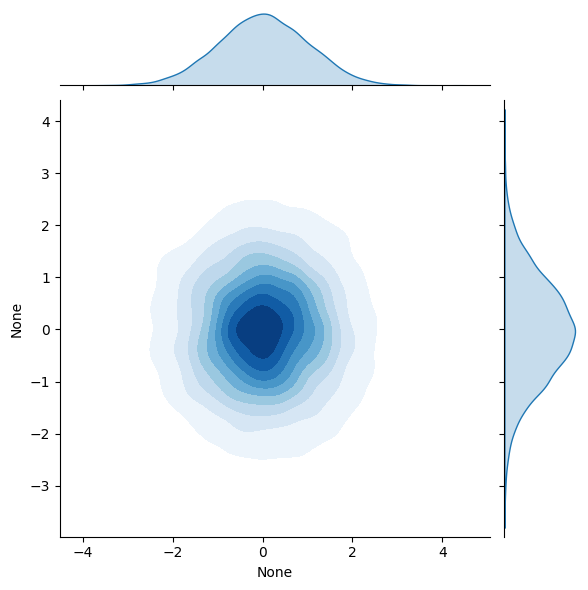

In [ ]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

from torch.distributions import MultivariateNormal
import seaborn as sns # This is for visualization
mean = torch.Tensor([0, 0]) # Center the mean at the origin
covariance = torch.Tensor( # This matrix shows independence - there are only non-zero values on the diagonal
    [[1, 0],
     [0, 1]]
)
independent_dist = MultivariateNormal(mean, covariance)
samples = independent_dist.sample((10000,))
res = sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind="kde", cmap="Blues", fill=True)
plt.show()

Ahora un ejemplo de una distribución normal multivariante que tiene covarianza:

$\Sigma = \left(\begin{array}{cc}
2 & -1\\
-1 & 2
\end{array}\right)
$

Y vemos que aspecto tiene:


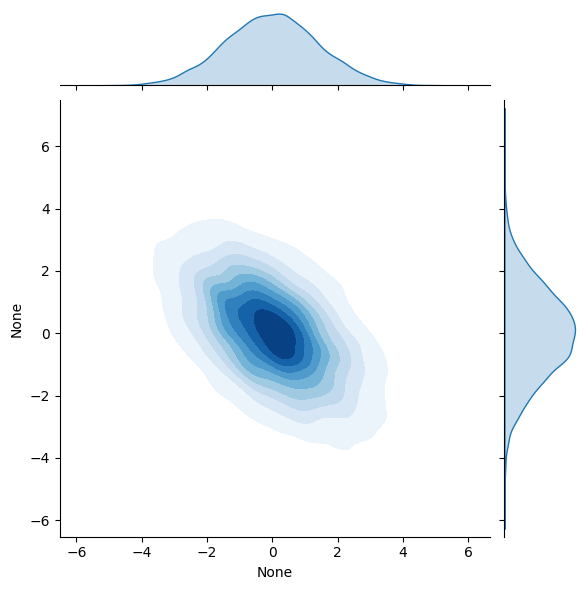

In [ ]:
mean = torch.Tensor([0, 0])
covariance = torch.Tensor(
    [[2, -1],
     [-1, 2]]
)
covariant_dist = MultivariateNormal(mean, covariance)
samples = covariant_dist.sample((10000,))
res = sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind="kde", cmap="Blues", fill=True)
plt.show()

**Fórmula**

Basándonos en el artículo "[La distancia de Fréchet entre distribuciones normales multivariantes](https://core.ac.uk/reader/82269844)" de Dowson y Landau (1982), la distancia de Fréchet entre dos distribuciones normales multivariantes $X$ y $Y$ es:

$d(X, Y) = \Vert\mu_X-\mu_Y\Vert^2 + \mathrm{Tr}\left(\Sigma_X+\Sigma_Y - 2 \sqrt{\Sigma_X \Sigma_Y}\right)$

De forma similar a la fórmula de la distancia de Fréchet univariante, puede calcular la distancia entre las medias y la distancia entre las desviaciones típicas. Sin embargo, el cálculo de la distancia entre las desviaciones típicas cambia ligeramente aquí, ya que incluye el producto de matrices y la raíz cuadrada de matrices. $\mathrm{Tr}$ se refiere a la traza, la suma de los elementos diagonales de una matriz.

¡Ahora puede implementar esto!

<details>

<summary>
<font size="3" color="green">
<b>Pista opcional para <code><font size="4">frechet_distance</font></code></b>
</font>
</summary>

1.   Quieres implementar la ecuación anterior en código.
2.   Las funciones `torch.norm` y `torch.trace` te resultará útiles en este caso.
3.   La función matrix_sqrt está definida a continuación -- necesitas usarla en lugar de `torch.sqrt()` que sólo obtiene la raíz cuadrada elemental en lugar de la raíz cuadrada matricial.
4.   También puedes usar el símbolo `@` para multiplicar matrices.
</details>

In [ ]:
import scipy
# This is the matrix square root function you will be using
def matrix_sqrt(x):
    '''
    Function that takes in a matrix and returns the square root of that matrix.
    For an input matrix A, the output matrix B would be such that B @ B is the matrix A.
    Parameters:
        x: a matrix
    '''
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

In [ ]:
# C2: Completa el código donde corresponde:
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    '''
    Function for returning the Fréchet distance between multivariate Gaussians,
    parameterized by their means and covariance matrices.
    Parameters:
        mu_x: the mean of the first Gaussian, (n_features)
        mu_y: the mean of the second Gaussian, (n_features)
        sigma_x: the covariance matrix of the first Gaussian, (n_features, n_features)
        sigma_y: the covariance matrix of the second Gaussian, (n_features, n_features)
    '''
    #### START CODE HERE ####
    return None
    #### END CODE HERE ####

In [ ]:
# Comprobación (NO TOCAR nada, Solo ejecutar)

mean1 = torch.Tensor([0, 0]) # Center the mean at the origin
covariance1 = torch.Tensor( # This matrix shows independence - there are only non-zero values on the diagonal
    [[1, 0],
     [0, 1]]
)
dist1 = MultivariateNormal(mean1, covariance1)

mean2 = torch.Tensor([0, 0]) # Center the mean at the origin
covariance2 = torch.Tensor( # This matrix shows dependence
    [[2, -1],
     [-1, 2]]
)
dist2 = MultivariateNormal(mean2, covariance2)

assert torch.isclose(
    frechet_distance(
        dist1.mean, dist2.mean,
        dist1.covariance_matrix, dist2.covariance_matrix
    ),
    4 - 2 * torch.sqrt(torch.tensor(3.))
)

assert (frechet_distance(
        dist1.mean, dist1.mean,
        dist1.covariance_matrix, dist1.covariance_matrix
    ).item() == 0)

print("Success!")

Success!


## ¡Todo junto!
Ahora, puedes aplicar FID al generador de antes.

Definimos código de ayuda para preprocesar la imagen para la red Inception-v3:
<!-- This isn't exactly what FID is meant for, since inception scores expect a natural image, but it should give a rough idea of the diversity and quality of your images.  [TODO: move to bottom since image net is trained on nature (cat, dog) images, fidelity (quality)] -->

In [ ]:
def preprocess(img):
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    return img

A continuación, definimos una función para calcular la covarianza de las características que devuelve una matriz de covarianza dada una lista de valores:

In [ ]:
import numpy as np
def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

Por último, utilizamos el modelo Inception-v3 preentrenado para calcular las características de las imágenes reales y falsas. Con estas características, puede obtener la covarianza y la media de estas características a través de muchas muestras.

En primer lugar, se obtienen las características de las imágenes reales y falsas utilizando el modelo Inception-v3:

In [ ]:
fake_features_list = []
real_features_list = []

gen.eval()
n_samples = 512 # The total number of samples
batch_size = 4 # Samples per iteration

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True)

cur_samples = 0
with torch.no_grad(): # You don't need to calculate gradients here, so you do this to save memory
    try:
        for real_example, _ in tqdm(dataloader, total=n_samples // batch_size): # Go by batch
            real_samples = real_example
            real_features = inception_model(real_samples.to(device)).detach().to('cpu') # Move features to CPU
            real_features_list.append(real_features)

            fake_samples = get_noise(len(real_example), z_dim).to(device)
            fake_samples = preprocess(gen(fake_samples))
            fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')
            fake_features_list.append(fake_features)
            cur_samples += len(real_samples)
            if cur_samples >= n_samples:
                break
    except:
        print("Error in loop")

  0%|          | 0/128 [00:00<?, ?it/s]


### Vamos a repasar lo realizado:

+ En el código tomamos 512 muestras que vamos recorriendo en lotes de 4 en 4
+ Obtenemos su vector de caracteristiacas con Incepction-v3: un vector de 2048 caracteristicas para cada muestra.
+ Los vamos metiendo en una lista: 124 elementos de 4 vectores cada uno de 2048 caracteristicas


A continuación, combina (concatenar, función cat()) todos los valores que has recopilado para los reales y los falsos en grandes tensores:

In [ ]:
# C3: Completa el código donde corresponde:
fake_features_all = None
real_features_all = None

Ahora de cada imagen real ya tenemos nuestro Tensor de 512 elementos de 2048 caracteristicas (features) extraidas!
Y lo mismo de las imágenes falsas!

Y calcula la covarianza y la media de estas características reales y falsas:

In [ ]:
# C4: Completa el código donde corresponde:

# Calculate the covariance matrix for the fake and real features
# and also calculate the means of the feature over the batch (for each feature dimension mean)
#### START CODE HERE ####
mu_fake = None
mu_real = None
sigma_fake = None
sigma_real = None
#### END CODE HERE ####

In [ ]:
# Comprobación (NO TOCAR nada, Solo ejecutar)
#Esto puede dar error si no coinciden bien las imágenes... IGNORAR
assert tuple(sigma_fake.shape) == (fake_features_all.shape[1], fake_features_all.shape[1])
assert torch.abs(sigma_fake[0, 0] - 2.5e-2) < 1e-2 and torch.abs(sigma_fake[-1, -1] - 5e-2) < 1e-2
assert tuple(sigma_real.shape) == (real_features_all.shape[1], real_features_all.shape[1])
assert torch.abs(sigma_real[0, 0] - 3.5768e-2) < 1e-4 and torch.abs(sigma_real[0, 1] + 5.3236e-4) < 1e-4
assert tuple(mu_fake.shape) == (fake_features_all.shape[1],)
assert tuple(mu_real.shape) == (real_features_all.shape[1],)
assert torch.abs(mu_real[0] - 0.3099) < 0.01 and torch.abs(mu_real[1] - 0.2721) < 0.01
assert torch.abs(mu_fake[0] - 0.37) < 0.05 and torch.abs(mu_real[1] - 0.27) < 0.05
print("Success!")

En este punto, también puedes visualizar cómo son las distribuciones multivariantes por pares de las características de inicio.

Para ello definimos 3 indices y generamos 3 distribuciones Normales Multivariables con media (mu) y desv.standard (sigma) de cada uno de los elementos definidos con los indices

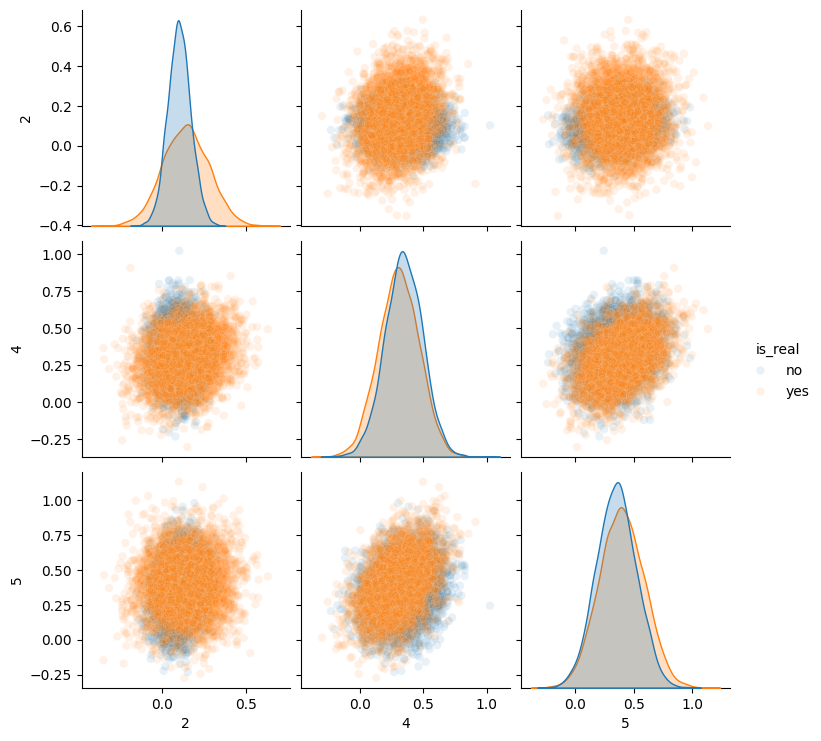

In [ ]:
indices = [2, 4, 5]
fake_dist = MultivariateNormal(mu_fake[indices], sigma_fake[indices][:, indices])
fake_samples = fake_dist.sample((5000,))
real_dist = MultivariateNormal(mu_real[indices], sigma_real[indices][:, indices])
real_samples = real_dist.sample((5000,))

import pandas as pd
df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
df_real = pd.DataFrame(real_samples.numpy(), columns=indices)
df_fake["is_real"] = "no"
df_real["is_real"] = "yes"
df = pd.concat([df_fake, df_real])
sns.pairplot(df, plot_kws={'alpha': 0.1}, hue='is_real')

Por último, puede utilizar su función anterior `frechet_distance` para calcular el FID y evaluar su GAN. Puedes ver cómo de similares/diferentes son las características de las imágenes generadas a las características de las imágenes reales.

(La próxima celda puede tardar hasta 10' dependiendo del recurso utilizado)

In [ ]:
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

135.79429626464844


Voila! Ese número obtenido es el valor de la FID

Observarás que este modelo obtiene un FID bastante alto, probablemente superior a 30. Dado que cuanto más bajo, mejor, y que los mejores modelos de CelebA obtienen puntuaciones de **un solo dígito**, está claro que este modelo tiene mucho camino por recorrer!. Puedes utilizar la FID para comparar diferentes modelos, así como diferentes etapas de entrenamiento del mismo modelo.

###Enhorabuena!
has completado lo necesario y ya puedes calcular la FID en tus modelos GAN

## Referencias

+ Notebook basado en ejercicios de [DeepLearning.AI](https://www.deeplearning.ai/)
+ Documentación de [PyTorch](https://pytorch.org/docs/stable/index.html)

# EOF